In [ ]:
import numpy as np
import escnn.gspaces as gspaces
import escnn.nn as enn
import escnn
import torch
import torch.nn as nn
import torch.optim as optim

import random
import math
import time
import tqdm
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
from sympy.combinatorics import Permutation, PermutationGroup

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

PATH = os.getcwd()

### Generate Adjacency Matrices

In [ ]:
class Node:
    def __init__(self, position, xadj, yadj):
        self.position = position
        self.xadj = xadj
        self.yadj = yadj
    
    def __str__(self):
        return f"{self.position} {self.xadj} {self.yadj}"

In [ ]:
def squareAdjacencyList(a,b): # constructs a periodic adjacency graph with width a and height b
    nodes = []
    for j in range(0,b):
        for i in range(0,a):
            xadj = [[(i-1) % a,j],[(i+1) % a,j]]
            yadj = [[i,(j-1) % b],[i,(j+1) % b]]
            nodes.append(Node([[i,j]],xadj,yadj))

    return nodes

### First Neighbors Adjacency Matrix

In [ ]:
def firstneighbors(a,b): 
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for xptr in nodes[i].xadj:
                if xptr in nodes[j].position:
                    flag = True
            for yptr in nodes[i].yadj:
                if yptr in nodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return torch.tensor(J, dtype=torch.float, requires_grad=True)

### Second Neighbors (Euclidean) Adjacency Matrix

In [ ]:
def secondneighbors(a,b):
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False

            for xptr in nodes[i].xadj:
                try:
                    for k in range(0,N):
                        if xptr in nodes[k].position:
                            intermediate = k
                    for yptr in nodes[intermediate].yadj:
                        if yptr in nodes[j].position:
                            flag = True
                except UnboundLocalError:
                    pass

            if flag:
                J[i][j] = 1
                J[j][i] = 1

    return torch.tensor(J, dtype=torch.float, requires_grad=True)

### Model Parameters

In [ ]:
a = 4 # x-range of supercell
b = 4 # y-range of supercell
N1 = firstneighbors(a,b)
N2 = secondneighbors(a,b)
n = a*b # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

### Define G-CNN Model

In [ ]:
# Define the group and input/output types
gspace = gspaces.rot2dOnR2(N=4)  # Example for rotation group of order 4 (D4)
input_type = enn.FieldType(gspace, [gspace.trivial_repr])  # Scalar fields
output_type = enn.FieldType(gspace, 2*[gspace.trivial_repr])  # Single scalar output

In [ ]:
class PeriodicConvLayer(enn.EquivariantModule):
    def __init__(self, in_type, out_type, kernel_size):
        super(PeriodicConvLayer, self).__init__()
        
        self.kernel_size = kernel_size
        self.conv = enn.R2Conv(in_type, out_type, kernel_size, padding=0)
        
    def periodic_padding(self, x, padding):
        return torch.nn.functional.pad(x, padding, mode='circular')
        
    def forward(self, x):
        padding = self.kernel_size // 2
        x = self.periodic_padding(x.tensor, (padding, padding, padding, padding))
        x = enn.GeometricTensor(x, self.conv.in_type)
        return self.conv(x)
    
    def evaluate_output_shape(self, input_shape):
        padding = self.kernel_size // 2
        return self.conv.evaluate_output_shape(input_shape[:-2] + (input_shape[-2] + 2 * padding, input_shape[-1] + 2 * padding))

In [ ]:
# Define the network
class GCNN(nn.Module):
    def __init__(self):
        super(GCNN, self).__init__()
        
        self.block1 = PeriodicConvLayer(input_type, enn.FieldType(gspace, 8*[gspace.regular_repr]), kernel_size=4)
        self.block2 = PeriodicConvLayer(enn.FieldType(gspace, 8*[gspace.regular_repr]), enn.FieldType(gspace, 16*[gspace.regular_repr]), kernel_size=4)
        self.block3 = PeriodicConvLayer(enn.FieldType(gspace, 16*[gspace.regular_repr]), output_type, kernel_size=4)
        self.pool = enn.PointwiseAvgPoolAntialiased(output_type, sigma=0.66, stride=1)

        self.gpool = enn.GroupPooling(output_type)     
        self.linear = nn.Linear(98, 2)
        
    def forward(self, x):
        x = enn.GeometricTensor(x, input_type)
        x = self.block1(x)
        x = nn.functional.relu(x.tensor)
        x = enn.GeometricTensor(x, self.block2.conv.in_type)
        x = self.block2(x)
        x = nn.functional.relu(x.tensor)
        x = enn.GeometricTensor(x, self.block3.conv.in_type)
        x = self.block3(x)
        x = self.pool(x)
        x = self.gpool(x)
        x = torch.flatten(x.tensor, 1)
        x = self.linear(x)
        return x

In [ ]:
model = GCNN().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

In [ ]:
def findAdjStates(initState): ### takes some basis state and returns a list of all other states that have a nonzero Hamiltonian with it
    otherStates = []
    
    for i in range(n-1):
        for j in range(i+1,n):
            if (N1[i][j] != 0 or N2[i][j] !=0) and initState[i]*initState[j] == -1:
                tempState = initState.clone()
                tempState[i],tempState[j] = initState[j],initState[i]
                otherStates.append(tempState)                

    return otherStates
    
def computeExplicitHamEntry(state1,state2,J1,J2,diagonal):
    sum = 0.0
    if diagonal:
        for k in range(0,n-1):
            for l in range(k+1,n):
                if (N1[k][l] != 0):
                    sum += J1*state1[k]*state2[l]
                if (N2[k][l] != 0):
                    sum += J2*state1[k]*state2[l]          
    else:
        tempState = state1 * state2
        if (torch.count_nonzero(tempState == -1) == 2):
            indices = torch.nonzero(torch.eq(tempState,-1),as_tuple=False)
            e,f = indices[0][0],indices[1][0]
            if (N1[e][f] != 0):
                sum += 2*J1
            if (N2[e][f] != 0):
                sum += 2*J2
    
    return torch.tensor(sum,dtype=torch.float,requires_grad=True)

def modulus(x):
    return x[0]**2+x[1]**2

def locEnergy(model,initState,coeff,J1,J2):
    re = torch.tensor(0.0,dtype=torch.float,requires_grad=True)
    im = torch.tensor(0.0,dtype=torch.float,requires_grad=True)
    others = findAdjStates(initState)
    for x in others:
        c_x = model(torch.tensor(x.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        H_x = computeExplicitHamEntry(initState,x,J1,J2,False)
        re = torch.add(re,c_x[0][0]*H_x)
        im = torch.add(re,c_x[0][1]*H_x)
    ref = (coeff[0][0]*re+coeff[0][1]*im)/modulus(coeff[0])
    imf = (coeff[0][0]*im-coeff[0][1]*re)/modulus(coeff[0])
    ref = torch.add(ref,computeExplicitHamEntry(initState,initState,J1,J2,True))
    print(ref,imf)
    return ref,imf

def metropolis(model,initState,coeff):
    proposedState = torch.tensor([1]*(n-n0)+[-1]*n0, dtype=torch.float, requires_grad=True)
    proposedState = proposedState[torch.randperm(proposedState.size(0))]
    newCoeff = model(torch.tensor(proposedState.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
    acceptanceProb = min(1,(modulus(newCoeff[0])/modulus(coeff[0])))
    bernTrial = torch.bernoulli(torch.tensor([acceptanceProb],dtype=torch.float, requires_grad=True))
    if bernTrial == 1:
        return proposedState
    else:
        return initState

def sampleEnergy(model,batchSize,J1,J2): ### takes in basis state index
    ignore = 10 # number of MCMC steps to ignore (in order to reduce correlation)
    state = torch.tensor([1]*(n-n0)+[-1]*n0, dtype=torch.float, requires_grad=True)
    state = state[torch.randperm(state.size(0))]
    for i in range(ignore):
        c = model(torch.tensor(state.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        state = metropolis(model,state,c)

    sum = 0.0
    for step in range(batchSize):
        c = model(torch.tensor(state.reshape(1,1,a,b), dtype=torch.float, requires_grad=True))
        sum += locEnergy(model,state,c,J1,J2)[0]
        state = metropolis(model,state,c)
    
    return sum / batchSize

### Test Energy Sampling

In [ ]:
H = sparse.load_npz(PATH +'/'+str(a)+'x'+str(b)+'hamiltonian.npz')
H = H.toarray()

coeffList = [model(torch.tensor(stateTable[i].reshape(1,1,a,b),dtype=torch.float,requires_grad=True)).item() for i in tqdm.tqdm(range(N))]    

  0%|          | 0/12870 [00:00<?, ?it/s]C:\Users\jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
 18%|█▊        | 2278/12870 [00:11<00:56, 187.56it/s]

KeyboardInterrupt: 

In [ ]:
coeffList = np.array(coeffList)
coeffList /= np.linalg.norm(coeffList)
energy = coeffList.T @ H @ coeffList
print(energy)

batches = [5,10,20,100]
supersamples = []
for k in range(4):
    samples = []
    for count in tqdm.tqdm(range(50)):
        samples.append(sampleEnergy(model,batches[k],1,0))
    supersamples.append(samples)

28.513141943530087


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
  2%|▏         | 1/50 [01:26<1:10:53, 86.81s/it]


KeyboardInterrupt: 

In [ ]:
newlists = []
for vals in supersamples:
    newlist = []
    for val in vals:
        newlist.append(val.item())

    newlists.append(newlist)

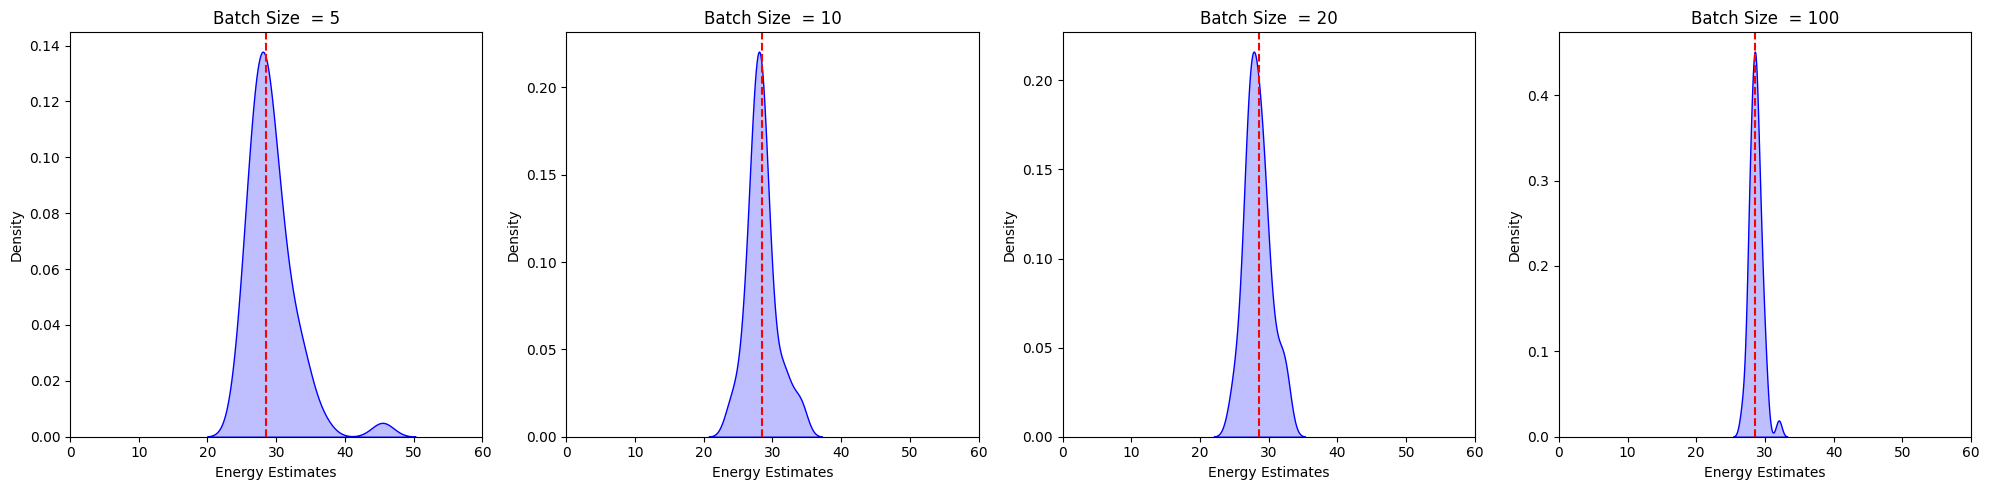

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
for k in range(4):
    sns.kdeplot(newlists[k], fill=True, ax=axes[k], color='blue')
    axes[k].set_title('Batch Size  = '+str(batches[k]))
    axes[k].set_xlim(0,60)
    axes[k].set_xlabel('Energy Estimates')
    axes[k].axvline(x=energy, color='red', linestyle='--')
plt.tight_layout()
plt.show()